### About

This project is about [a challenge from Kaggle](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/) to predict the demographic information of mobile users.

This notebook is greatly inspired by [the notebook](https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/brand-and-model-based-benchmarks).

## Data Description

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

In [10]:
# list the data files
os.listdir('../data')

['gender_age_test.csv', 'gender_age_train.csv', 'phone_brand_device_model.csv']

#### Gender-Age-Group

In [4]:
df_gender_age_train = pd.read_csv('../data/gender_age_train.csv')
df_gender_age_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


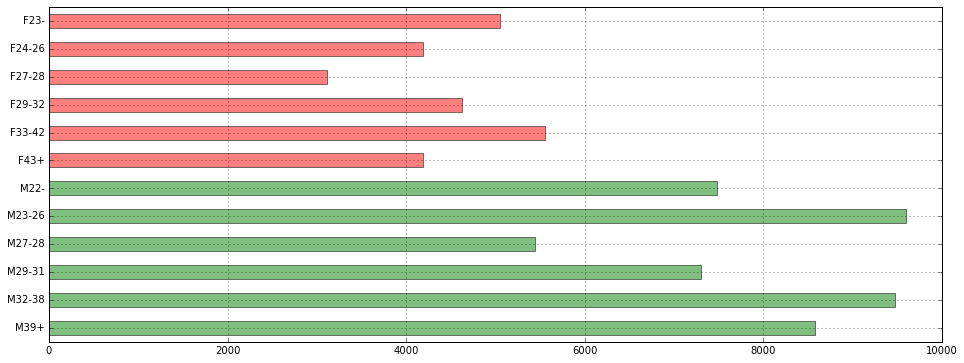

In [5]:
gender_age_group = df_gender_age_train.group.value_counts().sort_index(ascending=False)

color_array = ['g' for i in np.arange(6)] + ['r' for i in np.arange(6)]

''' plot the data in horizontal bars. '''
plt.figure()
gender_age_group.plot(kind='barh', color=color_array,
                      alpha=0.5, grid=True, figsize=(16, 6))
plt.show()

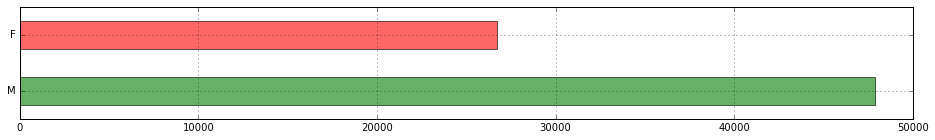

In [6]:
df_gender_age_train.gender.value_counts().plot(kind='barh',
    color=['g', 'r'], alpha=0.6, grid=True, figsize=(16, 2))

In [7]:
gender_age_dist = df_gender_age_train.groupby(['gender', 'age']).size()

age_range = np.arange(df_gender_age_train.age.min(),
                      df_gender_age_train.age.max())

gender_age_dist = gender_age_dist.unstack(level=0)

gender_age_dist = gender_age_dist.reindex(index=age_range).fillna(0)

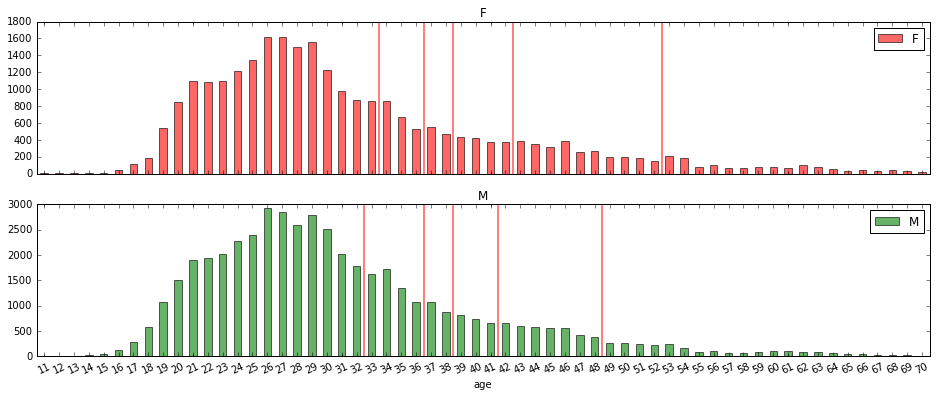

In [94]:
plt.figure()
ax1, ax2 = gender_age_dist.iloc[10:70].plot(kind='bar',
                                figsize=(16,6),
                                subplots=True,
                                color=['r', 'g'], alpha=0.6)
# xlabels = ['%i' % i for i in age_range]
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25)

# plot separated lines in the subplots
ax1.vlines(np.array([23,26,28,32,42])-0.5,0,1800,alpha=0.5,linewidth=2,color='r')
ax2.vlines(np.array([22,26,28,31,38])-0.5,0,3000,alpha=0.5,linewidth=2,color='r')

plt.show()

#### Phone Brand & Model

In [11]:
df_phone_brand_device_model = pd.read_csv('../data/phone_brand_device_model.csv')

In [12]:
df_phone_brand_device_model.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


## Classification 

In the next code section, we first encode the label of age groups with a number, so that we could use that for the model building and model evaluation.

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss

# encode the group labels with integar number of 0 to num_classes
group_label_encoder = LabelEncoder().fit(df_gender_age_train.group.values)

group_labels = group_label_encoder.transform(df_gender_age_train.group.values)

### Non-Preference Assignment

A naive strategy to predict the probability that a sample could be assigned to a group, is to assume that each group has an equal probability.

In [167]:
num_class = len(group_label_encoder.classes_)

# the assignment to each class with equal probability.
equal_pred = np.ones((len(df_gender_age_train), num_class)) / num_class

print('log_loss of non-preference prediction:', log_loss(group_labels, equal_pred))

log_loss of non-preference prediction: 2.48490664979


### Cross Validation Assignment

Another naive strategy of prediction, is to assume the probability of a sample to be assigned to a group is proportional to the *priori* propability of a group in the training dataset.

In addition, we could use the **cross validation** method to divide the dataset into ```N``` folds, then we use the ```N-1``` folds as the training dataset to do the prediction for each fold.

- Create N-folds out of the original data
- For each fold, use the rest of the folds to do the prediction.

In [181]:
from sklearn.cross_validation import KFold

kf = KFold(len(group_labels), n_folds=10, shuffle=True, random_state=None)

x_valid_pred = np.zeros((len(df_gender_age_train), num_class))

for train_index, test_index in kf:
    train_X = df_gender_age_train.iloc[train_index, :]
    test_X = df_gender_age_train.iloc[test_index, :]
    
    pred = train_X.groupby('group').size() / len(train_X)
    x_valid_pred[test_index, :] = pred

print('log_loss of cross validation prediction:',
      log_loss(group_labels, x_valid_pred))

log_loss of cross validation prediction: 2.42804066037
